201920915 박영빈 기계학습 기말고사      

커널: python 3.10.13        
데이터: amazon_uk_shoes_products_dataset_2021_12.csv



        
review_rating을 중앙값 기준으로 중앙값 이상 긍정(1)과  중앙값 미만 부정(0)을 나누어 라벨로 사용      
review_title과 review_text를 텍스트 토큰화 및 불용어 제거한 뒤 표제어 추출을 하여 하나의 review 변수로 저장하고     
이것을 TF-IDF 백터화해 SVC 모델로 학습 진행      


In [1]:
%pip install nltk
%pip install scikit-learn
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords') # 불용어 다운로드
nltk.download('punkt') # 토큰화를 위한 데이터 다운로드

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [373]:
# csv 데이터 읽기
df = pd.read_csv("./amazon_uk_shoes_products_dataset_2021_12.csv")

# 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6823 entries, 0 to 6822
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                6823 non-null   object 
 1   product_name       6823 non-null   object 
 2   reviewer_name      6823 non-null   object 
 3   review_title       6822 non-null   object 
 4   review_text        6814 non-null   object 
 5   review_rating      6823 non-null   float64
 6   verified_purchase  6823 non-null   bool   
 7   review_date        6823 non-null   object 
 8   helpful_count      1953 non-null   object 
 9   uniq_id            6823 non-null   object 
 10  scraped_at         6823 non-null   object 
dtypes: bool(1), float64(1), object(9)
memory usage: 539.8+ KB


11개의 열(변수)     
6823개의 행(데이터)     

In [374]:
# 필요없는 데이터 제거
# 제품 이름과 리뷰 정보만 남기고 제거
# 리뷰가 도움이 된 사람 숫자인 helpful_count은 사용 여지가 있어 남김
df = df.drop(columns=["url", "reviewer_name", "review_date", "uniq_id", "scraped_at", "verified_purchase"])

# 결측치 확인
df.isna().sum()

product_name        0
review_title        1
review_text         9
review_rating       0
helpful_count    4870
dtype: int64

In [375]:
# review_title과 review_text에 결측치가 존재하는 행 삭제
df = df.dropna(subset=["review_title", "review_text"], axis=0)

# 확인
df.isna().sum()

product_name        0
review_title        0
review_text         0
review_rating       0
helpful_count    4863
dtype: int64

In [376]:
# 결측치가 많은 helpful_count 데이터 확인
display(df.helpful_count)

# 리뷰가 도움이 된 사람이 없으면 NaN 결측치로 표기되는 것을 확인
# 리뷰가 도움이 된 사람이 1명인 경우 다르게 표기되는 것을 확인
display(df["helpful_count"].value_counts())

0       2 people found this helpful
1                               NaN
2                               NaN
3                               NaN
4       2 people found this helpful
                   ...             
6818                            NaN
6819                            NaN
6820                            NaN
6821                            NaN
6822                            NaN
Name: helpful_count, Length: 6813, dtype: object

helpful_count
One person found this helpful    850
2 people found this helpful      370
3 people found this helpful      174
4 people found this helpful      119
5 people found this helpful       80
6 people found this helpful       61
7 people found this helpful       50
9 people found this helpful       36
10 people found this helpful      32
8 people found this helpful       28
12 people found this helpful      18
11 people found this helpful      13
13 people found this helpful      12
19 people found this helpful       7
16 people found this helpful       7
22 people found this helpful       7
15 people found this helpful       6
23 people found this helpful       5
14 people found this helpful       5
35 people found this helpful       5
28 people found this helpful       5
26 people found this helpful       4
21 people found this helpful       4
17 people found this helpful       3
24 people found this helpful       3
29 people found this helpful       3
30 people found this hel

In [377]:
df["helpful_count"].fillna("0 people found this helpful", inplace=True)
df.loc[df[df["helpful_count"] == "One person found this helpful"].index, 'helpful_count'] = "1 people found this helpful"

/tmp/ipykernel_2300/4056830566.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["helpful_count"].fillna("0 people found this helpful", inplace=True)


In [378]:
# 변경사항 확인
df["helpful_count"].value_counts()

helpful_count
0 people found this helpful      4863
1 people found this helpful       850
2 people found this helpful       370
3 people found this helpful       174
4 people found this helpful       119
5 people found this helpful        80
6 people found this helpful        61
7 people found this helpful        50
9 people found this helpful        36
10 people found this helpful       32
8 people found this helpful        28
12 people found this helpful       18
11 people found this helpful       13
13 people found this helpful       12
16 people found this helpful        7
19 people found this helpful        7
22 people found this helpful        7
15 people found this helpful        6
23 people found this helpful        5
14 people found this helpful        5
35 people found this helpful        5
28 people found this helpful        5
26 people found this helpful        4
21 people found this helpful        4
29 people found this helpful        3
17 people found this helpful        

In [379]:
# 결측치가 모두 제거된 것을 확인
df.isna().sum()

product_name     0
review_title     0
review_text      0
review_rating    0
helpful_count    0
dtype: int64

In [380]:
# 결측치 처리 후 데이터 정보
display(df.info())

# 중복된 데이터 없음 확인
display(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 6813 entries, 0 to 6822
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_name   6813 non-null   object 
 1   review_title   6813 non-null   object 
 2   review_text    6813 non-null   object 
 3   review_rating  6813 non-null   float64
 4   helpful_count  6813 non-null   object 
dtypes: float64(1), object(4)
memory usage: 577.4+ KB


None

4

In [381]:
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer

# NLTK 데이터 다운로드
nltk.download('wordnet') # 표제어 추출
nltk.download('punkt') # 토큰화
nltk.download('stopwords') # 불 용어

# 불 용어 제거 함수
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    # 기호 제거
    text = re.sub(r'[^\w\s]', '', text)
    # 토큰화 및 불용어 제거
    tokens = nltk.word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)


# 표제어 추출 함수
# 표제어 추출은 단어들이 다른 형태를 가지더라도, 그 뿌리 단어를 찾아가서 단어의 개수를 줄일 수 있는지 판단
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


# 토큰화 후 불 용어, 기호 제거
df.review_title = df.review_title.apply(remove_stopwords)
df.review_text = df.review_text.apply(remove_stopwords)

# 토큰화 후 표제어 추출
df.review_title = df.review_title.apply(lemmatize_text)
df.review_text = df.review_text.apply(lemmatize_text)


# 리뷰 제목과 내용을 하나의 변수로 합침
df["review"] = df["review_title"] + df["review_text"]
# 확인
df.head(3)


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,product_name,review_title,review_text,review_rating,helpful_count,review
0,Klasified Women's Transparent Clear Sneaker Sh...,love em,love looking converse half price unique ive ne...,5.0,2 people found this helpful,love emlove looking converse half price unique...
1,Klasified Women's Transparent Clear Sneaker Sh...,plastic ripped,shoe cute day wearing tongue started ripping d...,2.0,0 people found this helpful,plastic rippedshoe cute day wearing tongue sta...
2,Klasified Women's Transparent Clear Sneaker Sh...,good quality,good quality,5.0,0 people found this helpful,good qualitygood quality


In [382]:
# 리뷰 점수는 1점부터 5점까지 숫자
display(df["review_rating"].value_counts())

# 리뷰 점수 대부분이 5점에 분포하고 있음
display(df["review_rating"].describe())

# 리뷰 점수로 라벨 만들기
median_points = df["review_rating"].median() # 리뷰 점수 중앙값
df["sentiment"] = df["review_rating"].apply(lambda x: 1 if x >= median_points else 0) # 중앙값 이상이면 긍정(1), 아닐 경우 부정(0)

df.sentiment.sum()

review_rating
5.0    4250
4.0     917
1.0     651
3.0     603
2.0     392
Name: count, dtype: int64

count    6813.000000
mean        4.133568
std         1.335986
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: review_rating, dtype: float64

4250

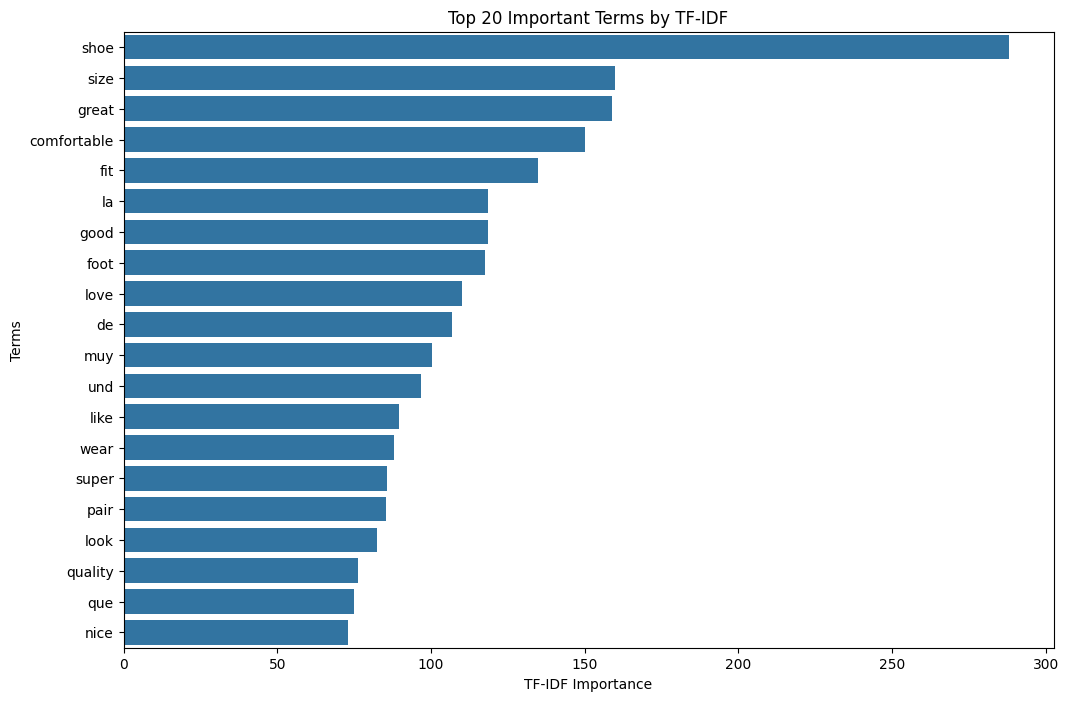

In [383]:
# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(df["review"], df["sentiment"], test_size=0.2, random_state=42)


# TF-IDF(단어 빈도-역 문서 빈도, Term Frequency-Inverse Document Frequency) 백터화
vectorizer = TfidfVectorizer(max_features=2000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# TF-IDF 벡터에서 각 단어의 중요도 추출
tfidf_scores = X_train_tfidf.toarray()
terms = vectorizer.get_feature_names_out()
importance = tfidf_scores.sum(axis=0)

# 상위 20개의 중요한 단어 추출
top_n = 20
top_indices = importance.argsort()[-top_n:][::-1]
top_terms = [terms[i] for i in top_indices]
top_importance = importance[top_indices]


# 상위 20개의 중요한 단어 빈도수 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x=top_importance, y=top_terms)
plt.xlabel('TF-IDF Importance')
plt.ylabel('Terms')
plt.title('Top 20 Important Terms by TF-IDF')
plt.show()

In [384]:
from sklearn.model_selection import GridSearchCV # 그리드 서치
from sklearn.svm import SVC # 분류 모델

# 그리드 서치할 하이퍼파라미터
# gamma: 하나의 훈련 샘플이 미치는 영향의 범위를 결정합니다
# C: 각 포인트의 중요도를 제한하는 매개변수로, 해당 값이 커질수록 결정경계가 데이터에 정확하게 맞춰집니다.
# 그리드 서치는 가장 적합한 하이퍼파라미터를 찾아주고 그 과정에서 교차 검증을 수행함 
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


# 지표상 성능이 더 좋지 않아 사용하지 않음
# 커널을 다항으로
# svc = SVC(kernel='poly')
# gs = GridSearchCV(svc, param_grid=params, return_train_score=True)


# 그리드 서치 설정
gs = GridSearchCV(SVC(), param_grid=params, return_train_score=True)

# 학습 시작
gs.fit(X_train_tfidf, y_train)


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

SVC 모델을 이용해 긍정과 부정을 분류했고, 이 모델은 SVM을 사용하여 분류 작업을 수행하는 모델입니다.

그리드 서치할 하이퍼파라미터        
gamma: 하나의 훈련 샘플이 미치는 영향의 범위를 결정합니다       
C: 각 포인트의 중요도를 제한하는 매개변수로, 해당 값이 커질수록 결정경계가 데이터에 정확하게 맞춰집니다.            

*GridSearchCV는 가장 적합한 하이퍼파라미터를 찾아주고 그 과정에서 교차 검증을 수행          

그리드 서치 결과        
C = 1       
gamma = 1       
일때 베스트 모델            

In [385]:
# 최적 모델
best_model = gs.best_estimator_

# 성능 평가용
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# 예측
y_pred = best_model.predict(X_test_tfidf)

# 평가
accuracy = accuracy_score(y_test, y_pred)   # 정확도
precision = precision_score(y_test, y_pred) # 정밀도
recall = recall_score(y_test, y_pred)       # 재현율
f1 = f1_score(y_test, y_pred)               # f1 score
roc_auc = roc_auc_score(y_test, y_pred)     # ROC-AUC

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)

# 혼동 행렬
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
print("Confusion Matrix:\n", cm)


Accuracy: 0.8165810711665444
Precision: 0.8130939809926082
Recall: 0.9134045077105575
F1 Score: 0.8603351955307262
ROC-AUC Score: 0.786509946162971
Confusion Matrix:
 [[770  73]
 [177 343]]


•	정확도 Accuracy: 0.8165810711665444     
정확도는 전체 예측 중에서 올바르게 예측한 비율을 나타냅니다.        
81.7%의 정확도로 모델이 전체 데이터를 잘 분류하고 있음을 의미합니다.        

•	정밀도 Precision: 0.8130939809926082        
정밀도는 모델이 긍정으로 예측한 것들 중 실제로 긍정인 비율을 나타냅니다.        
81.3%의 정밀도로 모델이 긍정 예측을 할 때 비교적 신뢰할 수 있음을 의미합니다.       

•	재현율 Recall: 0.9134045077105575       
재현율은 실제 긍정 중에서 모델이 올바르게 예측한 비율을 나타냅니다.     
91.3%의 재현율로 모델이 대부분의 긍정 사례를 잘 예측하고 있음을 의미합니다.     

•	F1 Score: 0.8603351955307262                
F1 점수는 정밀도와 재현율의 조화 평균입니다. 이 값은 두 지표 간의 균형을 제공합니다.            
86.0%의 F1 점수로 모델이 정밀도와 재현율 사이에서 균형을 잘 맞추고 있음을 나타냅니다.           

•	ROC-AUC Score: 0.786509946162971
ROC-AUC 점수는 ROC 곡선 아래의 면적을 나타냅니다. 1에 가까울수록 좋습니다.
0.787의 ROC-AUC 점수는 모델이 긍정과 부정을 잘 구분할 수 있음을 의미하지만, 완벽하지는 않습니다.


TP (True Positive): 긍정 클래스를 올바르게 예측한 수        
TN (True Negative): 부정 클래스를 올바르게 예측한 수        
FP (False Positive): 부정 클래스를 긍정 클래스로 잘못 예측한 수     
FN (False Negative): 긍정 클래스를 부정 클래스로 잘못 예측한 수     


1. 정확도 (Accuracy)        
Accuracy = (𝑇𝑃 + 𝑇𝑁) / (𝑇𝑃 + 𝑇𝑁 + 𝐹𝑃 + 𝐹𝑁)      
정확도는 전체 예측 중에서 올바르게 예측된 샘플의 비율.      
정확도는 모든 클래스의 예측 성능을 단순히 평균 내는 지표로, 클래스 불균형 문제가 없는 경우에 유용.      



2. 정밀도 (Precision)       
Precision = (𝑇𝑃 + 𝐹𝑃) / 𝑇𝑃      
정밀도는 모델이 긍정 클래스로 예측한 샘플 중 실제로 긍정 클래스인 샘플의 비율.      
정밀도는 FP를 줄이는 데 초점을 맞추는 지표로, 긍정 예측이 중요한 경우에 유용.       
​정밀도가 높으면 모델의 긍정 예측이 신뢰할 수 있음을 의미.              



3. 재현율 (Recall)      
Recall = (𝑇𝑃 + 𝐹𝑁) / 𝑇𝑃     
재현율은 실제 긍정 클래스 샘플 중에서 모델이 올바르게 예측한 샘플의 비율.       
재현율은 FN을 줄이는 데 초점을 맞추는 지표로, 긍정 클래스를 놓치지 않는 것이 중요한 경우에 유용.        
재현율이 높으면 모델이 긍정 클래스를 잘 포착하는 능력이 있음을 의미.        




4. F1 점수 (F1 Score)       
F1 Score = 2 * Precision * Recall / (Precision + Recall)        
F1 점수는 정밀도와 재현율의 조화 평균으로, 두 지표의 균형을 평가.       
정밀도와 재현율 간의 트레이드오프를 고려하여 최종 성능을 평가하는 데 유용.      
F1 점수는 정밀도와 재현율의 조화 평균을 사용하므로, 두 값이 모두 높을 때 높은 값을 가짐.        




5. ROC-AUC 점수 (ROC-AUC Score)     
ROC-AUC 점수는 모델의 분류 성능을 평가하는 또 다른 중요한 지표.     
ROC 곡선은 FPR (False Positive Rate)과 TPR (True Positive Rate) 간의 관계를 나타내며, AUC (Area Under the Curve)는 이 곡선 아래의 면적을 측정.      
ROC-AUC 점수는 0과 1 사이의 값을 가지며, 1에 가까울수록 모델의 분류 성능이 우수함을 의미.       
AUC 값이 높을수록 모델이 긍정 클래스와 부정 클래스를 잘 구분할 수 있음을 나타냄.        

True Positive Rate (TPR): 재현율과 동일     
False Positive Rate (FPR): 실제 부정 클래스 중에서 모델이 잘못 긍정 클래스로 예측한 비율        
FPR = (𝐹𝑃 + 𝑇𝑁) / 𝐹𝑃        
 


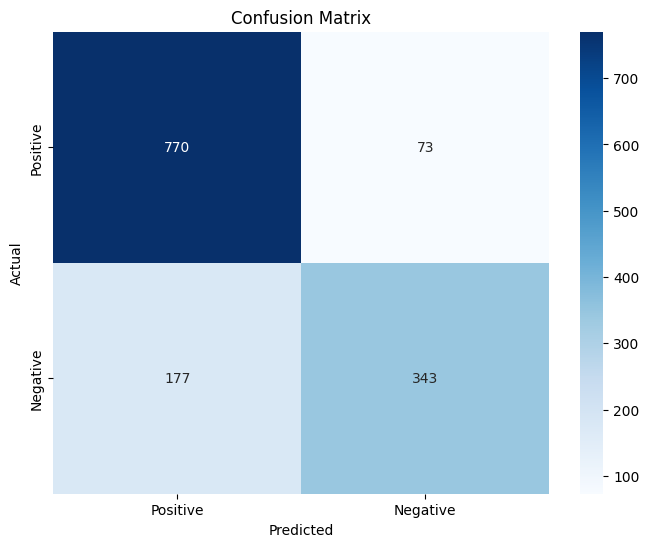

In [386]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

TP (770): 모델이 긍정으로 올바르게 예측한 수        
FP (177): 모델이 긍정으로 잘못 예측한 수        
FN (73): 모델이 부정으로 잘못 예측한 수     
TN (343): 모델이 부정으로 올바르게 예측한 수        

이 혼동 행렬을 통해 모델이 대부분의 긍정 사례와 부정 사례를 올바르게 예측하고 있음을 알 수 있습니다.

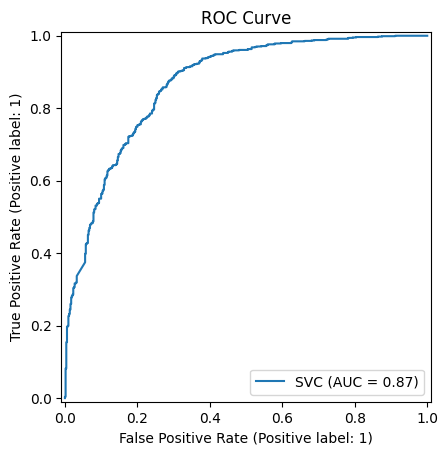

In [387]:
# ROC 곡선 시각화
RocCurveDisplay.from_estimator(best_model, X_test_tfidf, y_test)
plt.title('ROC Curve')
plt.show()

*결론 및 평가       
전처리 과정에서 review_rating 데이터 거의 대부분이 5점에 몰려있어 긍정과 부정 라벨로 변경할 때 기준점을 어디에 두어야 하는지가 힘들었습니다.        
텍스트를 불용어를 제외하고 표제어 추출해 백터화 하는 등의 작업은 모든 라이브러리가 주어져있어 처리하는데 크게 어려움은 없었던 것 같습니다.


정확도 (Accuracy): 81.7%로 모델이 전체적으로 좋은 성능을 보이고 있습니다.       
정밀도 (Precision): 81.3%로 긍정 예측의 신뢰성이 높습니다.      
재현율 (Recall): 91.3%로 모델이 대부분의 긍정 사례를 잘 예측하고 있습니다.      
F1 점수: 86.0%로 정밀도와 재현율 사이에서 균형을 잘 맞추고 있습니다.        
ROC-AUC 점수: 0.787로 모델이 긍정과 부정을 잘 구분하고 있습니다.        

In [388]:
# from nltk.sentiment.vader import SentimentIntensityAnalyzer # nltk의 VADER 감정 분석기
# nltk.download('vader_lexicon') # VADER 감정 분석기에 필요한 어휘 자료를 다운로드

# vader_sentiment = SentimentIntensityAnalyzer() # VADER 감정 분석기를 초기화

# # VADER 감정 분석기를 사용하여 감정 점수(컴파운드 스코어)를 계산하고 반환
# def calc_sentiment(review):    
#     return vader_sentiment.polarity_scores(review)["compound"]


# # 감정 점수를 계산해 df에 저장
# df["title_sentiment"] = df.review_title.apply(calc_sentiment)
# df["text_sentiment"] = df.review_text.apply(calc_sentiment)


# # 감정 점수를 양수이면 긍정(1), 아닐 경우 부정(0)으로 변환
# df["title_sentiment"] = df["title_sentiment"].apply(lambda x: 1 if x >= 0 else 0)
# df["text_sentiment"] = df["text_sentiment"].apply(lambda x: 1 if x >= 0 else 0)


# # 확인
# df.head()


In [389]:
# sentiment 확인
# 리뷰가 긍정일 경우 title_sentiment, text_sentiment 모두 평균 긍정(1)에 가까움
# df.groupby("rating_sentiment")[["title_sentiment", "text_sentiment"]].mean()